In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [41]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [42]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)
returns_index = returns_index.stack().rename("returns")

# # Portfolio returns
# period = (2001, 2004)
# cpis = dm.cpis.get_data(period=period)
# wb = dm.wb.get_data(countries=major, period=period)
# weights = compute_weights(cpis, wb, major, offshore).mean(axis=1).unstack(level="Country")
# returns_portfolio = compute_portfolio_excess_returns(ds, fed, major, weights)

# World market return
returns_world = compute_index_excess_returns(ds, fed, ["WR"]).to_numpy().flatten()
returns_world_dummies = pd.DataFrame(0.0, index=returns_index.index, columns=major)
for country in major:
    returns_world_dummies.loc[(country, slice(None)), country] = returns_world
returns_world_dummies.columns = ['WRx' + str(col) for col in returns_world_dummies.columns]

# GDP per capita
interpolate=False
period = (2001, 2004) if not interpolate else (2000,2004)
gdp_cap_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_cap_ppp")
gdp_cap_ppp = create_monthly_duplicates(gdp_cap_ppp, panel_dates, interpolate=interpolate)
gdp_cap_ppp = gdp_cap_ppp.stack().rename("gdp_cap")

# GDP growth (lagged yearly)
d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
lags = range(1,2)
for lag in lags:
    period = (2000-lag,2004-lag) if not interpolate else (1999-lag,2004-lag)
    gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
    d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
    d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, panel_dates, interpolate=interpolate)
    d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.stack().rename(f"lag{lag}")

# GDP growth (lagged monthly)
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# period = (1997,2004)
# n_lags = (2001 - period[0])*12
# columns = dm.ds.get_data(period=period, interval="M").columns[13:]
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
# d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
# d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, monthly_columns=columns, interpolate=interpolate)
# d_gdp_ppp
# lags = range(1, 37)
# for lag in lags:
#     d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.iloc[:, 36-lag:-lag].T.unstack().to_numpy()
# d_gdp_ppp_lag = d_gdp_ppp_lag.iloc[:, range(0,1)]

# Cumulative GDP growth
d_gdp_ppp_cum = d_gdp_ppp_lag.sum(axis=1)

# Variances (rolling window, exponential decay)
def calculate_exponentially_weighted_variance(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_index_historical = compute_index_excess_returns(ds, fed, major)
    variances = pd.DataFrame(index=major, columns=panel_dates)
    for i in range(48):
        returns = returns_index_historical.iloc[:,i:i+60]
        means = returns.mean(axis=1)
        returns_demeaned = returns.sub(means, axis=0)
        var_contributions = returns_demeaned**2
        factors = generate_exponential_decay(ratio=ratio)
        variances_temp = var_contributions.mul(factors).sum(axis=1) / sum(factors)
        variances.iloc[:,i] = variances_temp
    variances = variances.stack().rename("variances").astype(float)
    return variances
variances = calculate_exponentially_weighted_variance((1996,2004), panel_dates, 0.9)

def calculate_exponentially_weighted_return(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_world_historical = compute_index_excess_returns(ds, fed, ["WR"])
    expected_world_return = pd.DataFrame(index=["WR"], columns=panel_dates)
    for i in range(48):
        returns = returns_world_historical.iloc[:,i:i+120]
        factors = generate_exponential_decay(ratio=ratio, length=120)
        return_temp = returns.mul(factors).sum(axis=1) / sum(factors)
        expected_world_return.iloc[:,i] = return_temp
    return expected_world_return

In [43]:
from scipy.optimize import minimize_scalar

period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_index_historical = compute_index_excess_returns(ds, fed, major)
returns_index_demeaned = returns_index - returns_index.groupby("Country").mean()
returns_index_demeaned_squared = (returns_index_demeaned ** 2)

def compute_r2(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    # model = sm.OLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
    # model = PanelOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa), entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    model = PooledOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    return -model.rsquared


def compute_ss(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    errors = variances_kappa - returns_index_demeaned_squared
    ss = (errors ** 2).to_numpy().sum()
    return ss

kappa_ss = minimize_scalar(compute_ss, bounds=(0,1), method="bounded")
kappa_r2 = minimize_scalar(compute_r2, bounds=(0,1), method="bounded")
print(kappa_r2.x, kappa_ss.x)
print(kappa_r2.fun, kappa_ss.fun)

0.9058656466188171 0.8914021213249128
-0.16591934722811563 0.2678562235517841


In [44]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = PooledOLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

Dep. Variable:,returns,R-squared:,0.3081
Estimator:,PooledOLS,R-squared (Between):,0.9738
No. Observations:,1824,R-squared (Within):,0.0057
Date:,"Sat, May 03 2025",R-squared (Overall):,0.3081
Time:,00:28:16,Log-likelihood,5488.3
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,811.70
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(1,1823)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,122.74


In [45]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = sm.OLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
fe_model = PanelOLS(returns_index_demeaned_squared, variances_kappa, entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

from linearmodels.panel import compare

# Estimate both models
re_model = RandomEffects(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)

# Hausman test

comparison = hausman(fe_model, re_model)
print(comparison)

(np.float64(5.906802770555258), 1, np.float64(0.015082521769819666))


In [46]:
# Collect dependent and independent variables
scale = True
y = returns_index
X = pd.concat([
    variances,
    # gdp_cap_ppp / (1e5),
    d_gdp_ppp_cum,
    returns_world_dummies,
], axis=1)
X = sm.add_constant(X)

In [47]:
# Do statistics
from linearmodels.panel import PanelOLS, PooledOLS

model_panel = PanelOLS(y, X, entity_effects=True).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)
model_pooled = PooledOLS(y,X).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)

comparison = pd.DataFrame([model_pooled.params, model_panel.params], index=["pooled", "panel"])
date = model_panel.estimated_effects.index.get_level_values(1)[0]

effects = model_panel.estimated_effects.loc[(slice(None), date),:].droplevel(1)

if save is not None:
    save_dir = f"./output/exp3/results/"
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    with open(os.path.join(save_dir, f"{save}.txt"), "w") as f:
        f.write(model_panel.summary.as_text())
model_panel.summary

Dep. Variable:,returns,R-squared:,0.4443
Estimator:,PanelOLS,R-squared (Between):,-0.2583
No. Observations:,1824,R-squared (Within):,0.4443
Date:,"Sat, May 03 2025",R-squared (Overall):,0.4343
Time:,00:28:17,Log-likelihood,2619.1
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,34.897
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(40,1746)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,2.876e+05


In [48]:
# Expected world return
period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_world = compute_index_excess_returns(ds, fed, ["WR"])
returns_world_expectation = np.zeros(48)
for i in range(48):
    returns = returns_world.iloc[:,i:i+60]
    log_returns = np.log(1+returns) # New
    mean_log = log_returns.mean(axis=1).iloc[0] # New
    mean = returns.mean(axis=1).iloc[0]
    print(np.round(mean,4), np.round(np.exp(mean_log)-1,4))
    # returns_world_expectation[i] = np.exp(mean_log)-1 # New
    returns_world_expectation[i] = mean
# expected_world_returns = calculate_exponentially_weighted_return((1991,2004), panel_dates, 0.98).to_numpy().T
# returns_world_expectation = expected_world_returns

0.0062 0.0053
0.0063 0.0054
0.0048 0.0037
0.0033 0.0023
0.004 0.0029
0.0039 0.0028
0.0033 0.0022
0.0036 0.0025
0.0027 0.0016
0.0005 -0.0007
0.001 -0.0002
0.0012 0.0
0.0017 0.0005
0.0011 -0.0001
0.0008 -0.0004
0.002 0.0008
0.0012 -0.0
0.0002 -0.001
-0.0015 -0.0027
-0.0035 -0.0048
-0.0024 -0.0036
-0.0049 -0.0061
-0.0028 -0.0041
-0.002 -0.0033
-0.0028 -0.0041
-0.0036 -0.0049
-0.005 -0.0063
-0.0057 -0.007
-0.0044 -0.0057
-0.003 -0.0043
-0.0028 -0.0041
-0.0023 -0.0036
0.0006 -0.0006
0.0006 -0.0006
0.0001 -0.001
-0.0005 -0.0017
-0.0003 -0.0014
-0.0002 -0.0014
0.0006 -0.0005
-0.0001 -0.0012
-0.0013 -0.0024
-0.0007 -0.0018
-0.0013 -0.0024
-0.0018 -0.0029
-0.0017 -0.0028
-0.0011 -0.0023
-0.0015 -0.0026
-0.0012 -0.0023


In [64]:
params_for_estimation = model_panel.params.copy()
X_for_estimation = X.copy()
for country in major:
    world_return_header = "WRx" + country
    X_for_estimation.loc[(country, slice(None)), world_return_header] = returns_world_expectation
fitted_returns = (X_for_estimation * params_for_estimation)
fitted_returns = np.exp(fitted_returns.sum(axis=1).unstack())-1
temp = ((fitted_returns < 0).T)
def interpolate_negatives(row):
    # Mask negative values with NaN
    row = row.where(row >= 0, np.nan)
    # Interpolate within the row (axis=0 for row-wise here since row is a Series)
    return row.interpolate(method='linear', limit_direction='both')
# Apply row-wise
fitted_returns = fitted_returns.apply(interpolate_negatives, axis=1)
# print((fitted_returns < 0).sum(axis=1).T)
temp = temp[["KR", "CL", "TH", "GR", "HU"]]
temp

,KR,CL,TH,GR,HU
2001-01-31,False,False,False,False,False
2001-02-28,False,False,False,False,False
2001-03-31,False,False,False,False,False
2001-04-30,False,False,False,False,False
2001-05-31,False,False,False,False,False
2001-06-30,False,False,False,False,False
2001-07-31,False,False,False,False,False
2001-08-31,False,False,False,False,False
2001-09-30,False,False,False,False,False
2001-10-31,False,False,False,False,False


In [11]:
# Covariances
returns = returns_index.unstack()
returns_mean = returns.mean(axis=1)
returns_demeaned = returns.sub(returns_mean, axis=0)
stds = variances.map(lambda x: np.sqrt(x)).unstack()
standardised_returns = returns_demeaned / stds
corrs = standardised_returns.T.corr()
covs = pd.DataFrame(index=major, columns=pd.MultiIndex.from_product([stds.columns, major]))
for month in stds.columns:
    covs[month] = corrs.mul(stds[month],axis=1).mul(stds[month],axis=0)

In [12]:
# Covariance risks
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)
cov_risks = pd.DataFrame(index=covs.index, columns=covs.columns)
cov_risks_diag = pd.DataFrame(index=covs.index, columns=stds.columns)
for month in stds.columns:
    temp = covs[month] @ weights
    cov_risks[month] = temp
    cov_risks_diag[month] = np.diag(temp)

In [13]:
# eta * f
eta_f = fitted_returns / cov_risks_diag

C:\Users\nilsv\AppData\Local\Temp\ipykernel_11148\1486192545.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


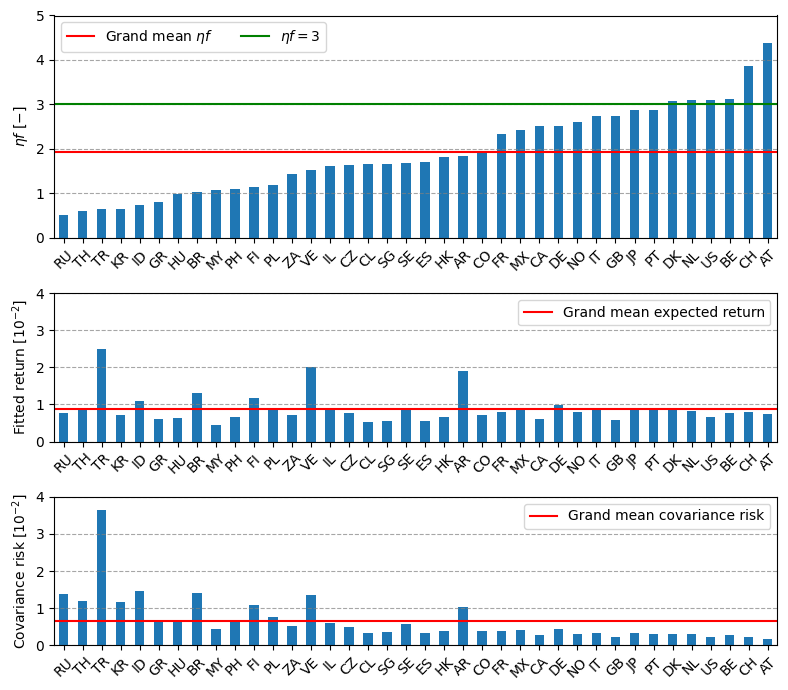

In [35]:
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(3, 1, figsize=(8,7), gridspec_kw={'height_ratios': [3, 2, 2]})

eta_f_mean = eta_f.mean(axis=1).sort_values()
eta_f_mean.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(eta_f_mean.mean(), color="red")
axs[0].axhline(3, color="green")
axs[0].legend(labels=[r"Grand mean $\eta f$", r"$\eta f = 3$"], ncol=2)
axs[0].set_ylabel(r"$\eta f$ $[\mathrm{-}]$") 
axs[0].set_ylim([0,5])

fitted_returns_mean = 100*fitted_returns.mean(axis=1).reindex(eta_f_mean.index)
fitted_returns_mean.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(fitted_returns_mean.mean(), color="red")
axs[1].legend(labels=["Grand mean expected return"], ncol=2)
axs[1].set_ylabel(r"Fitted return $[10^{-2}]$") 
axs[1].set_ylim([0,4])

cov_risks_mean = 100*cov_risks_diag.mean(axis=1).reindex(eta_f_mean.index)
cov_risks_mean.plot(kind="bar", ax=axs[2])
axs[2].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[2].get_xticklabels():
    label.set_ha('center')
axs[2].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[2].axhline(cov_risks_mean.mean(), color="red")
axs[2].legend(labels=["Grand mean covariance risk"], ncol=2)
axs[2].set_ylabel(r"Covariance risk $[10^{-2}]$") 
axs[2].set_ylim([0,4])

fig.tight_layout()
fig.savefig(dir+"/eta_f.svg")
fig.show()

In [36]:
eta_f_mean

RU    0.510252
TH    0.607643
TR    0.650043
KR    0.661272
ID    0.740077
GR    0.799804
HU    0.986037
BR    1.029725
MY    1.071902
PH    1.102897
FI    1.147724
PL    1.189667
ZA    1.429501
VE    1.528123
IL    1.613620
CZ    1.643146
CL    1.651372
SG    1.665584
SE    1.680169
ES    1.700974
HK    1.823135
AR    1.839864
CO    1.904992
FR    2.329397
MX    2.419075
CA    2.506399
DE    2.511345
NO    2.606647
IT    2.743267
GB    2.751310
JP    2.867911
PT    2.873536
DK    3.073302
NL    3.091763
US    3.109723
BE    3.113988
CH    3.871193
AT    4.386510
dtype: float64

In [15]:
# Fastest way
costs_9 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
for country_i in major:
    for month in stds.columns:
        costs_9[(month, country_i)] = fitted_returns[month] - eta_f.loc[country_i, month] * covs[month] @ weights[country_i] 
    print(country_i, end=" ")
costs = costs_9
print("\n")


AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



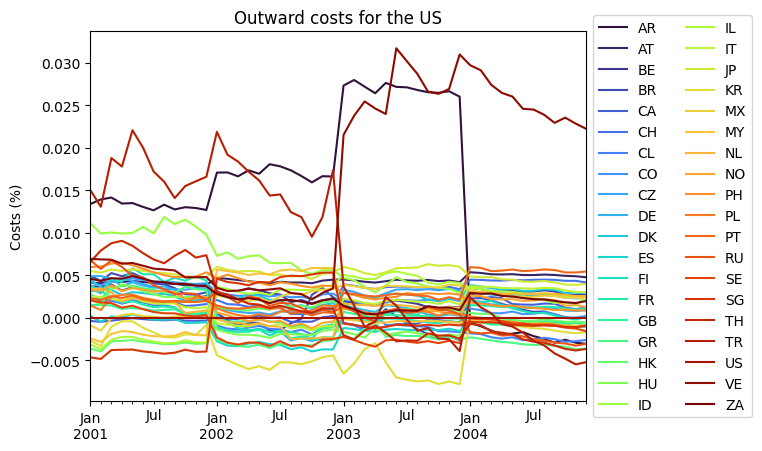

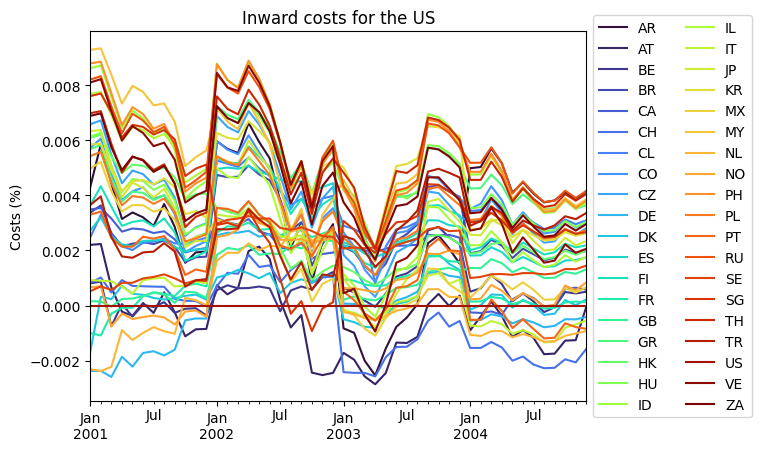

In [16]:
import matplotlib.cm as cm
data_outward = costs.loc[slice(None), (slice(None), "US")].T.droplevel(level=1)
data_inward = costs.loc["US"].unstack()
color = plt.get_cmap("turbo", 38)
ax = data_outward.plot(title="Outward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
ax = data_inward.plot(title="Inward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.show()

In [40]:
costs_mean.max().max(), costs_mean.min().min()

(np.float64(0.0225613598460167), np.float64(-0.0051619500074235256))

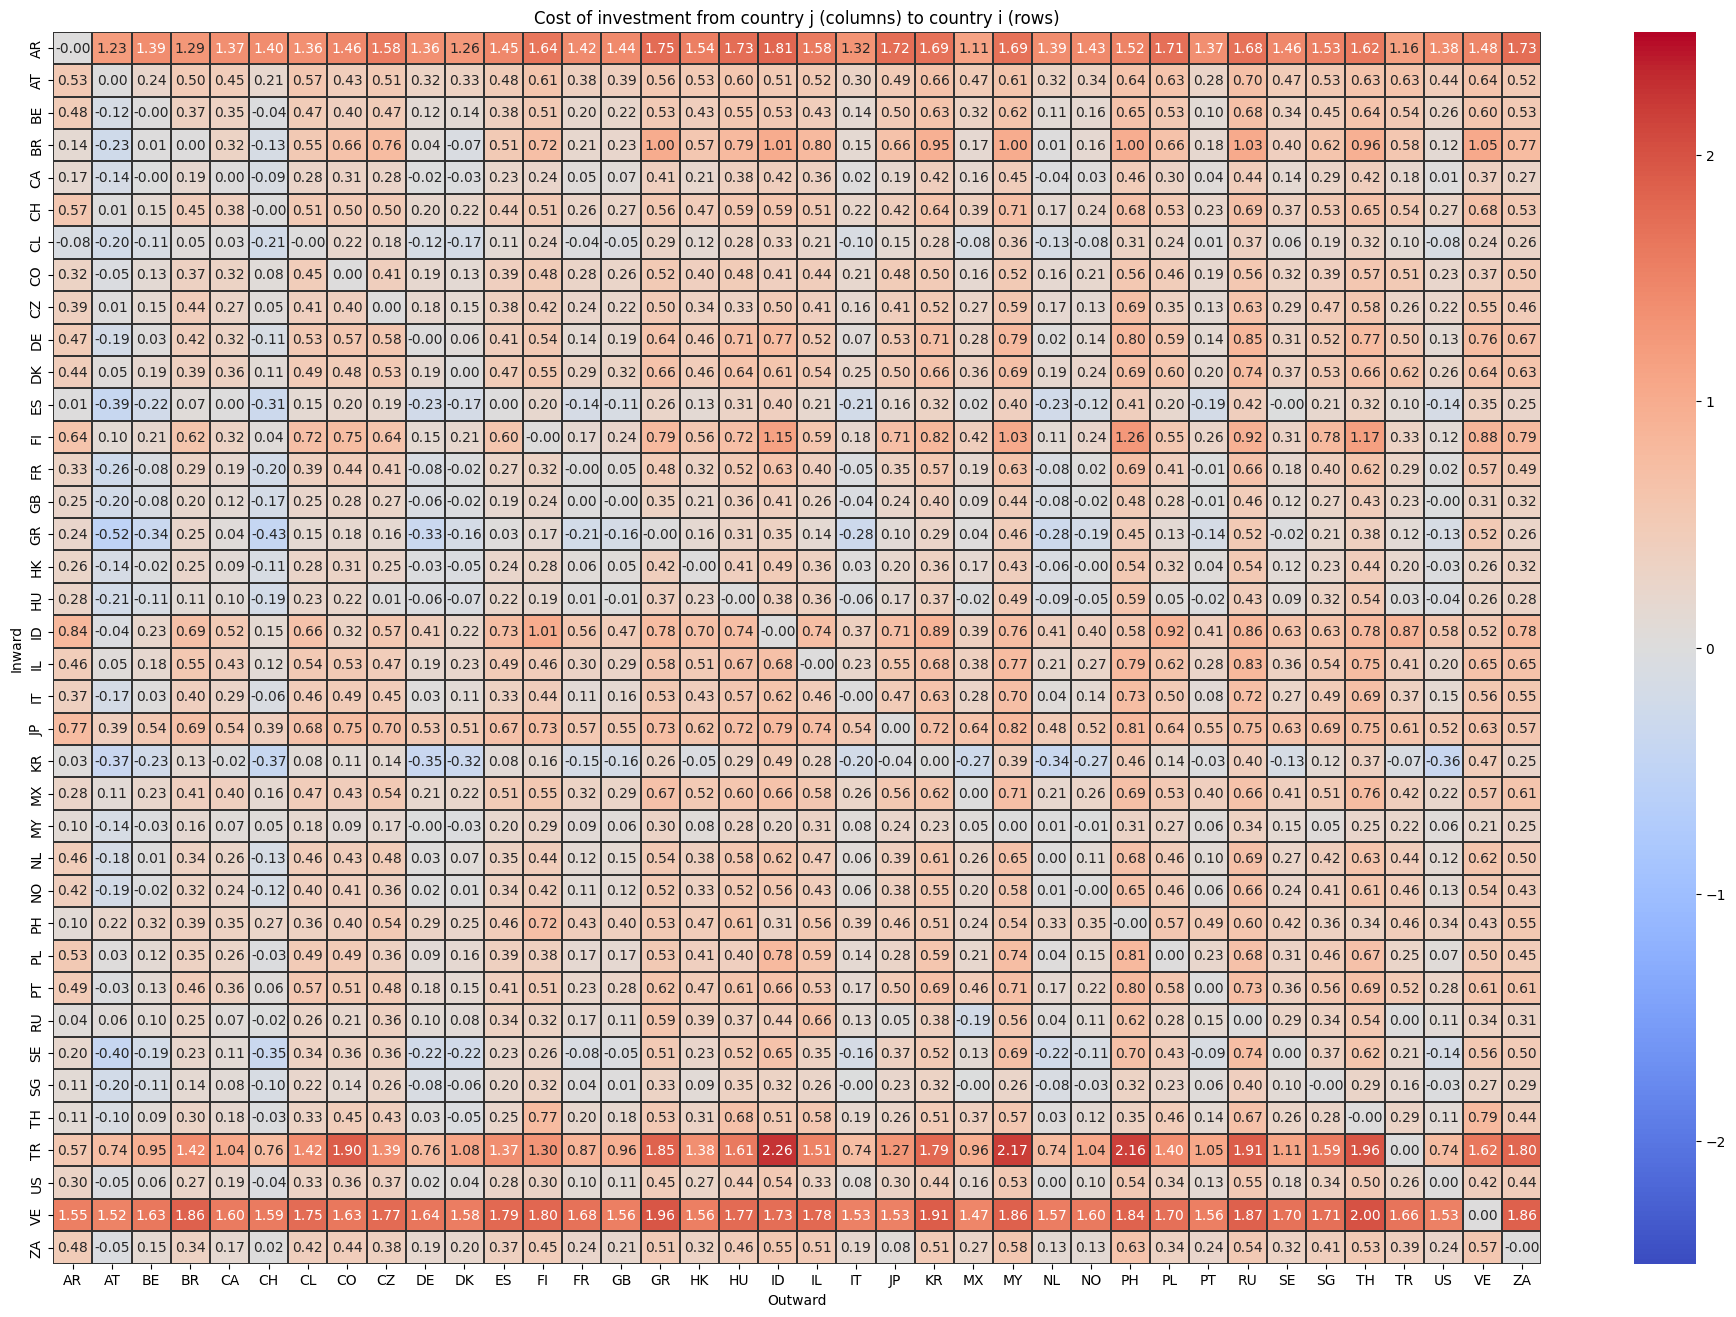

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
costs_mean = costs.T.groupby(level=1).mean().T
costs_mean = costs_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(100*costs_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

C:\Users\nilsv\AppData\Local\Temp\ipykernel_11148\233143010.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


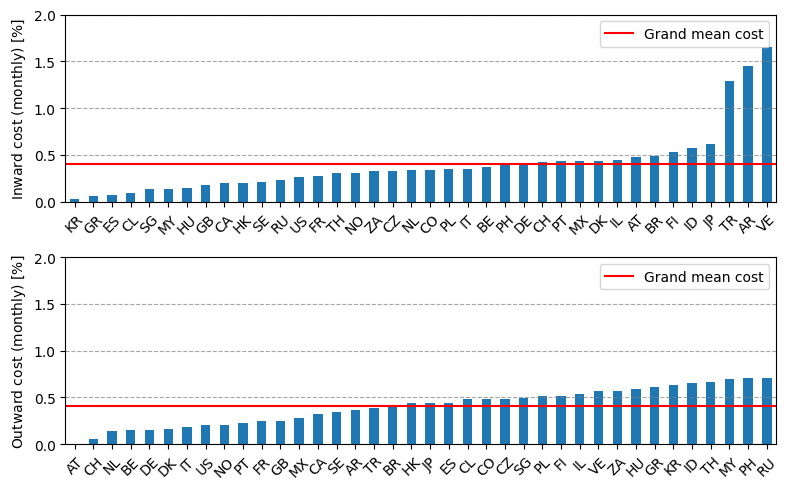

In [38]:
mean_inward_cost = costs_mean.mean(axis=1).sort_values() * 100
mean_outward_cost = costs_mean.mean(axis=0).sort_values() * 100
dir = os.path.abspath("../output/exp3/results/figures/")
fig, axs = plt.subplots(2, 1, figsize=(8,5), gridspec_kw={'height_ratios': [1,1]})

mean_inward_cost.plot(kind="bar", ax=axs[0])
axs[0].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[0].get_xticklabels():
    label.set_ha('center')
axs[0].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[0].axhline(mean_inward_cost.mean(), color="red")
axs[0].legend(labels=["Grand mean cost"], ncol=2)
axs[0].set_ylabel(r"Inward cost (monthly) $[\%]$") 
axs[0].set_ylim([0,2])

mean_outward_cost.plot(kind="bar", ax=axs[1])
axs[1].tick_params(axis='x', labelrotation=45, labelsize=10)
for label in axs[1].get_xticklabels():
    label.set_ha('center')
axs[1].grid(axis='y', linestyle='--', color='gray', alpha=0.7)
axs[1].axhline(mean_outward_cost.mean(), color="red")
axs[1].legend(labels=["Grand mean cost"], ncol=2)
axs[1].set_ylabel(r"Outward cost (monthly) $[\%]$") 
axs[1].set_ylim([0,2])

fig.tight_layout()
fig.savefig(dir+"/costs_mean.svg")
fig.show()

In [20]:
print("average over means: ", (costs_mean<0).sum().sum()/38**2)
print("average over all obs.: ", (costs_9<0).sum().sum()/38**2/48)

average over means:  0.11980609418282548
average over all obs.:  0.18572541551246538


In [20]:
cost_gap = pd.DataFrame(0.0, index=costs.index, columns=costs.columns)
for country_i in major: 
    for country_j in major:
        if country_j <= country_i:
            continue            
        for month in stds.columns:
            weights_i = weights[country_i]
            weights_j = weights[country_j]
            cov_i = covs[month].loc[country_i]
            cov_j = covs[month].loc[country_j]
            eta_f_i = eta_f.loc[country_i, month]
            eta_f_j = eta_f.loc[country_j, month]
            weights_diff = (3*(weights_i-weights_j) - (eta_f_i*weights_i - eta_f_j*weights_j))
            cost_gap.loc[country_i, (month, country_j)] =  cov_i @ weights_diff
            cost_gap.loc[country_j, (month, country_i)] =  cov_j @ -weights_diff
    print(country_i, end=" ")
print("\n")

AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



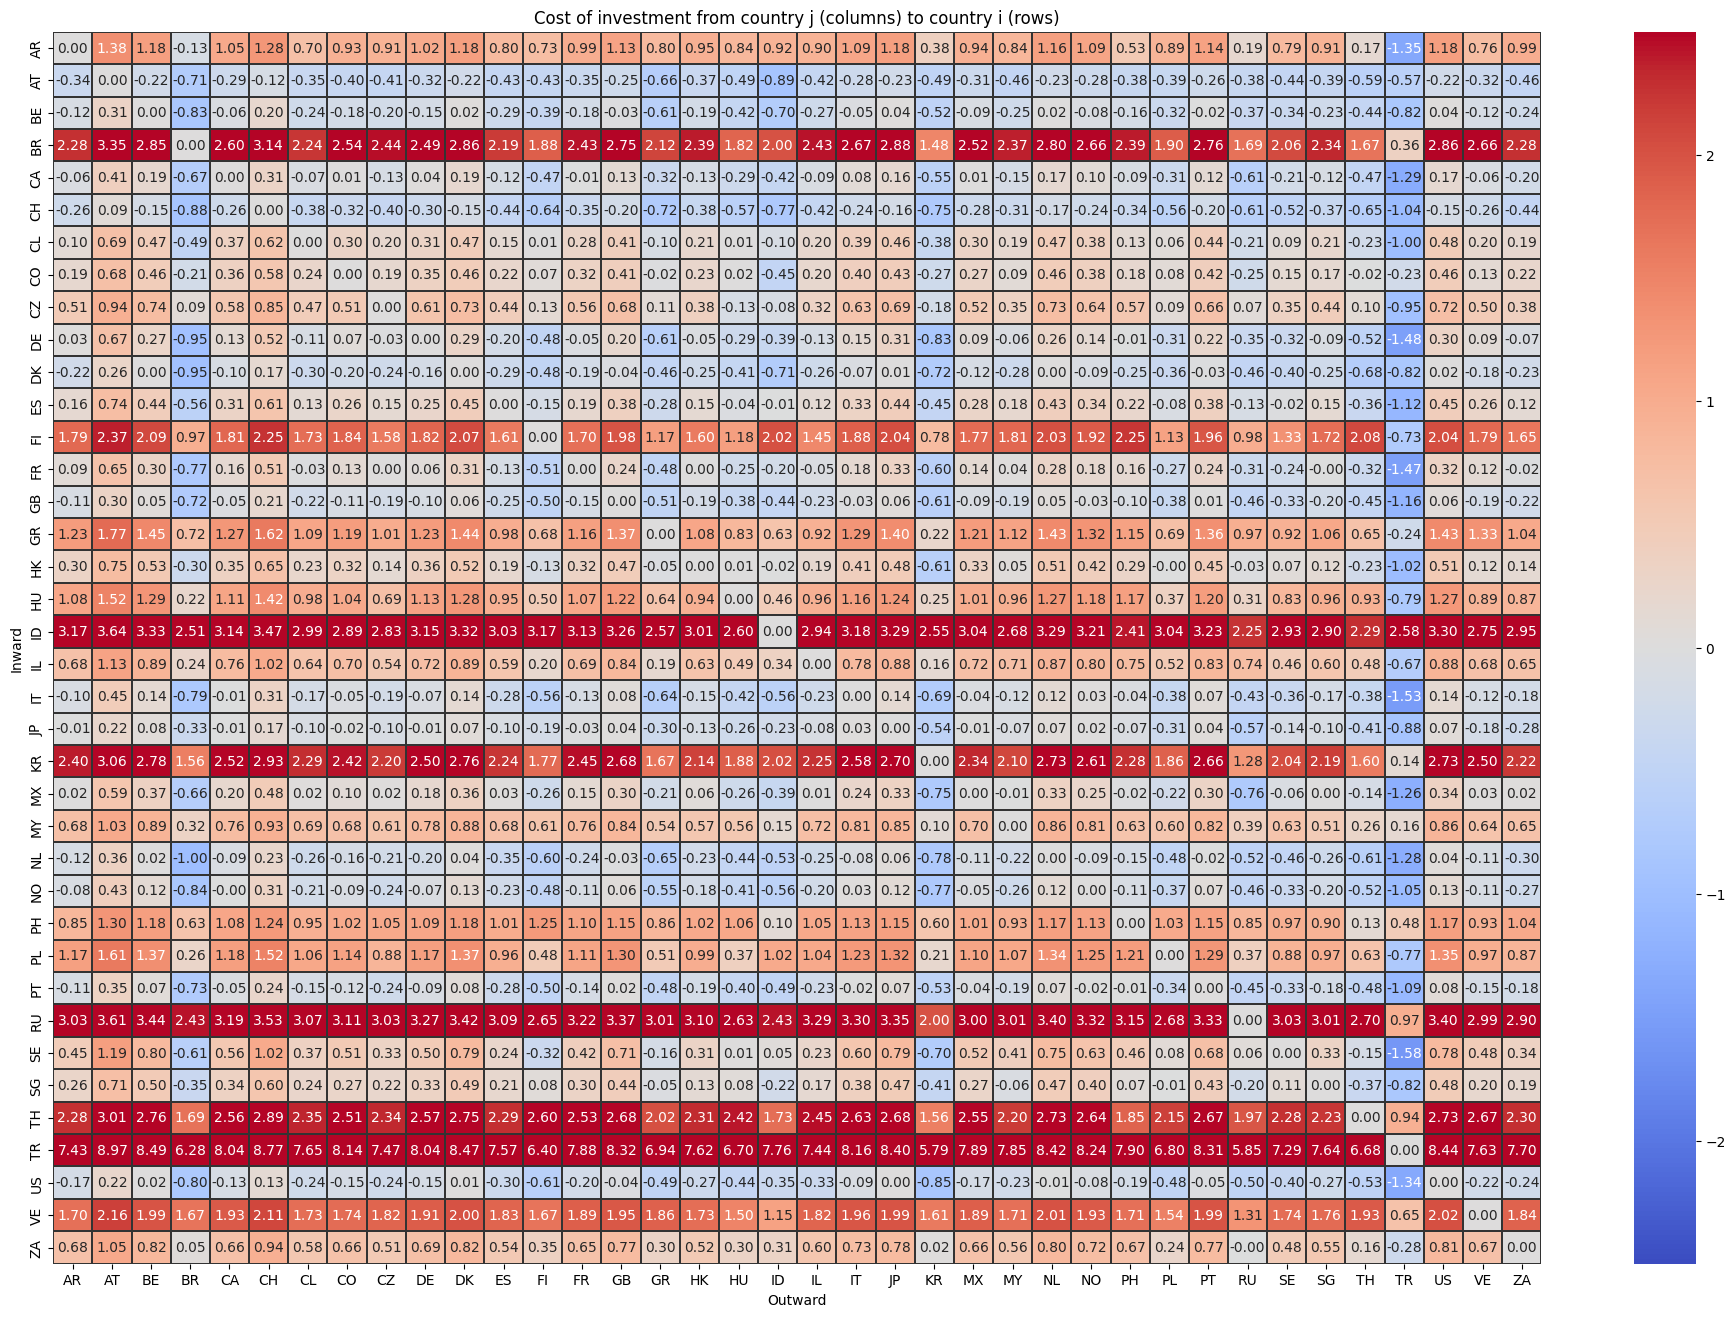

In [21]:
cost_gap_mean = 100*cost_gap.T.groupby(level=1).mean().T
cost_gap_mean = cost_gap_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(cost_gap_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

<Axes: >

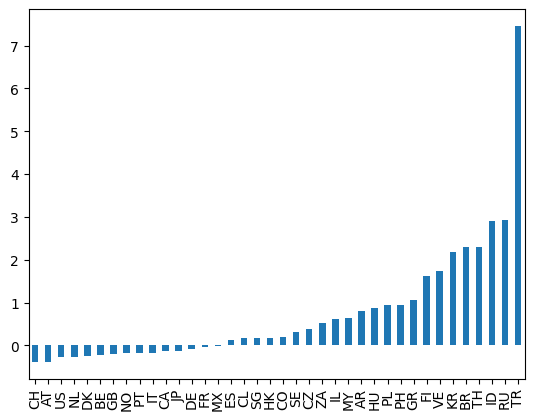

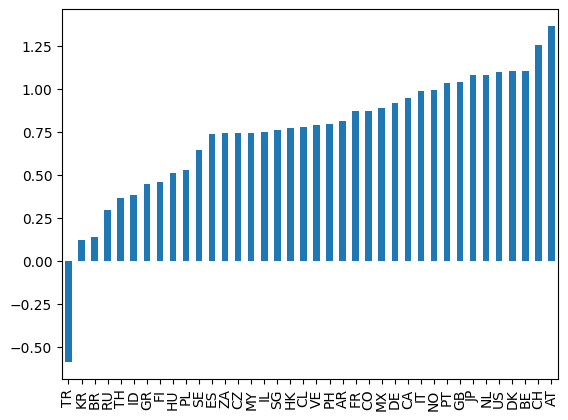

In [22]:
plt.figure()
cost_gap_mean.mean(axis=1).sort_values().plot(kind="bar")
plt.figure()
cost_gap_mean.mean(axis=0).sort_values().plot(kind="bar")
